## What does DataLoader do?
* loads images and labels
* normalize images
* discard not relevant label data (like segmentation, etc.)
* resize the images and adjust the labels of the bounding_boxes based on the resize
* randomize the order of the images and labels (matching them)
* convert the labels representation from (x_1, y_1, x_2, y_2, class) to (c_1, c_2, height, width, confidence, (classes in one_hot)) -> (annotations)
* We create s x s subgrids. Based on where the center (c_1, c_2) of a label is, we determine in which subgrid a certain label will fall. -> (grid_annotations)
    * example: the image is 64x64, s=2, and we have 3 bounding_boxes, the first centered in c_A = (1,1), the second c_B = (1, 35), the third c_C = (35, 35):
        * c_A label is inside the upper-left subgrid
        * c_B label is inside the upper-right subgrid
        * c_C label is inside the lower-right subgrid
        
Oss:
* with subgrids we are able to detect at most s*s different bounding_boxes
* we cannot detect two different bounding_boxes inside the same subgrid (this may be changed, we could try to detect two bounding_boxes for each subgrid, as YOLO does). Anyway we can increase the number of subgrids s

## Data we are going to use
We are going to use category and bounding box data, out objective is object detection, hence we will ignore data about segmentation, localization, etc.

In [779]:
import os
import pandas as pd
import random as rand
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

#TODO Convert labels from the original format of the dataset to (x1,x2,y1,y2,class). We are interested in annotation['item1']['bounding_box'] and annotation['item1']['category_id']. Note there can be more than one item per image
#TODO Convert labels from (x1,x2,y1,y2,class) to (c1,c2,height,width,confidence,class) 
#        (confidence is the IoU between the bounding box of the prediction and the bounding box of the ground truth, in the labels it must be set to one)
class DataLoader:
    annotations = {}
    images = []
    random_shuffling_for_file_indexes = []
    #annotations_grid_form = []
    grid_annotations = []
    
    
    def __init__(self, number_of_samples, images_folder, annotations_folder, grid_shape = (3,3), normalize=True, randomize=True, rescale_shape = (256, 256), subgrids = 4, number_of_classes = 13):
        self.number_of_samples = number_of_samples
        self.images_folder = images_folder
        self.annotations_folder = annotations_folder
        self.grid_shape = grid_shape
        self.rescale_shape = rescale_shape
        self.randomize = randomize
        self.subgrids = subgrids
        self.number_of_classes = number_of_classes
        if self.randomize:
            self._random_shuffling()
        self.images = self.load_n_images()
        self.annotations = self.load_n_annotations()
        self.cleanup_annotations()
        self.rescale()
        self.convert_annotations_onehot_and_xy_to_center_height_width()
        self.annotation_to_grid_form()
        if normalize:
            self.normalize_image()
    
    #use the same shuffling for both images and annotations
    def _random_shuffling(self):
        self.random_shuffling_for_file_indexes = [i for i in range(0, len(self.get_file_names_in_directory(self.images_folder)))]
        rand.shuffle(self.random_shuffling_for_file_indexes)

    def get_file_names_in_directory(self,directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

    def load_n_annotations(self):
        annotation = []
        counter = 0
        file_names = self.get_file_names_in_directory(self.annotations_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            annotation.append(pd.read_json(os.path.join(self.annotations_folder, file_names[self.random_shuffling_for_file_indexes[i]] if self.randomize else file_names[i])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return annotation
    
    #Removes unnecessary data
    def cleanup_annotations(self):
        for annotation in self.annotations:
            annotation.drop(labels=["source", "pair_id"], axis="columns", inplace=True)
            annotation.drop(labels=["segmentation", "scale", "viewpoint", "zoom_in", "landmarks", "style", "occlusion"], axis="index", inplace=True)
    
    #Reformats the data in ((c1,c2),w,h,confidence,class) where class is a one-hot vector of the 13 classes
    def convert_annotations_onehot_and_xy_to_center_height_width(self):
        #there are 13 classes
        classes = [i for i in range(1, self.number_of_classes+1)]

        for i, annotation in enumerate(self.annotations):
            newItems = []
            for (itemID, itemData) in annotation.items():
                boundingbox = itemData["bounding_box"]
                center_1 = boundingbox[0]+(boundingbox[2]/2)
                center_2 = boundingbox[1]+(boundingbox[3]/2)
                height = boundingbox[2]
                width = boundingbox[3]
                confidence = 1
                
                newItem = [center_1, center_2, height, width, confidence] + [self.category_id_to_one_hot(itemData["category_id"])]
                newItems.append(newItem)

            self.annotations[i] = pd.DataFrame(data=newItems, columns=["center_1", "center_2", "height", "width", "confidence", "class_one_hot"]).T
            
    def category_id_to_one_hot(self, category_id):
        one_hot_category_id = []
        number_of_classes = 13
        for i in range(1, number_of_classes+1):
            one_hot_category_id.append(1 if category_id == i else 0)
        return one_hot_category_id
    
    def load_n_images(self):
        images = []
        counter = 0
        images_names = self.get_file_names_in_directory(self.images_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            images.append(mpimg.imread(os.path.join(self.images_folder, images_names[self.random_shuffling_for_file_indexes[i]] if self.randomize else images_names[i])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return images
    
    def rescale(self):
        print("Rescaling")
        for i in range(len(self.images)):
            print(str(i) + ") ")
            im_old_shape = self.rescale_image(self.rescale_shape, i)
            self.rescale_annotation(self.rescale_shape, im_old_shape, i)
            clear_output(wait=True)
        
    def rescale_image(self, im_new_size, idx):
        print("Rescaling an image")
        img_temp = self.images[idx].copy()
        im = Image.fromarray(img_temp)
        img_old_shape = im.size
        im = im.resize(im_new_size)
        self.images[idx] = np.array(im)
        #delete the copied image
        del img_temp
        return img_old_shape
        
    def rescale_annotation(self, im_new_size, im_old_size, idx):
        #for every annotation, adjust the position of the points, based on the rescale of the data
        x_coefficient = im_new_size[0] / im_old_size[0]
        y_coefficient = im_new_size[1] / im_old_size[1]
        print("Rescaling an annotation")
        for (itemID, itemData) in self.annotations[idx].items():
            #print("................. .item id...............................: " + itemID)
            #print(self.annotations[0])
            itemData["bounding_box"][0] = itemData["bounding_box"][0] * x_coefficient
            itemData["bounding_box"][1] = itemData["bounding_box"][1] * y_coefficient
            itemData["bounding_box"][2] = itemData["bounding_box"][2] * x_coefficient
            itemData["bounding_box"][3] = itemData["bounding_box"][3] * y_coefficient
    
    def annotation_to_grid_form(self):
        annotation_grid_form = []
        for annotation in self.annotations:
            grid_annotation = self.initialize_empty_grid_annotation()
            for (itemID, itemData) in annotation.items():
                self.put_item_data_into_grid(itemData, grid_annotation)
            annotation_grid_form.append(grid_annotation)
        self.grid_annotations = annotation_grid_form
               
    def initialize_empty_cell_annotation(self):
        return np.zeros(shape=(5+self.number_of_classes))
    
    def initialize_empty_grid_annotation(self):
        return np.zeros(shape=(4, 4, 5+self.number_of_classes))
    
    def put_item_data_into_grid(self, itemData, grid_annotation):
        center_1 = itemData["center_1"]
        center_2 = itemData["center_2"]
        height = itemData["height"]
        width = itemData["width"]
        confidence = itemData["confidence"]
        #class_one_hot is also a list
        class_one_hot = itemData["class_one_hot"]
        (x, y) = self.find_sub_grid_coordinates_of_point(center_1, center_2)
        annotation_list = [center_1, center_2, height, width, confidence] + class_one_hot
        grid_annotation[x][y] = np.array(annotation_list)
        
    
    def find_sub_grid_coordinates_of_point(self, p_1, p_2):
        return (int(c_1 / sub_grid_shape), int(c_2 / sub_grid_shape))
        
    def normalize_image(self):
        for i in range(0, len(self.images)):
            self.images[i] = self.images[i] / 255

In [780]:
images_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/images/"
annotations_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/annotations/"
images_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/images/"
annotations_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/annotations/"

In [781]:
def get_file_names_in_directory(directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

In [782]:
dataset_10_examples = DataLoader(number_of_samples = 10,
               images_folder = images_train_folder_path,
               annotations_folder = annotations_train_folder_path)

9) 
Rescaling an image
Rescaling an annotation


In [783]:
assert len(dataset_10_examples.images) == 10
assert len(dataset_10_examples.annotations) == 10

### Check the number of Labels - 13 labels

In [784]:
# DEPRECATED CODE, WAS USED AT THE BEGINNING TO CHECK HOW MANY LABELS THERE WAS IN THE DATASET
def show_labels_sorted(dataset):
    category_ids_already_found = []
    for i in range(0, len(dataset.annotations)):
        actualCategoryId = dataset.annotations[i][0]["category_id"]
        if(not(actualCategoryId in category_ids_already_found)):
            category_ids_already_found.append(actualCategoryId)
    category_ids_already_found.sort()
    return category_ids_already_found
def count_labels(dataset):
    return len(show_labels_sorted(dataset))

# an example
Annotations are given in 2 formats:
* the normal annotation has a dataframe containing
    * the center point c_1, c_2
    * height, computed considering c the center point
    * width, computed considering c the center point
    * confidence, IoU between prediction and ground truth (always 1 is labels)
    * classes in one_hot form
* the grid representation: it is a matrix of shape s x s x 18
    * s*s is the number of subgrids we consideer from the image
    * 18 is given from 5 (c_1, c_2, height, width, confidence) + 13 (number of classes)
    
Oss: Each cell tries to predict one bounding_box for some class, it will also compute a confidence score. During test we will consideer which bounding_box to use based on confidence

In [801]:
example_annotations = dataset_10_examples.annotations[0]
example_annotations_grid = dataset_10_examples.grid_annotations[0]
display(example_annotations)
print("resized shape of an img: " + str(dataset_10_examples.images[0].shape))
print("shape of a grid label: " + str(example_annotations_grid.shape))

,0,1
center_1,151.521368,190.905983
center_2,155.897436,283.897436
height,205.675214,216.615385
width,176.866097,255.635328
confidence,1,1
class_one_hot,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


resized shape of an img: (256, 256, 3)
shape of a grid label: (4, 4, 18)


### Draw a box from a training sample to see what the json label represents

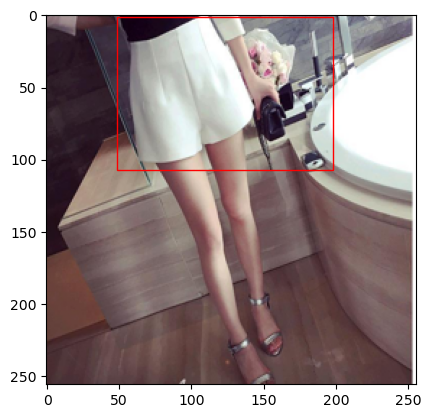

In [792]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#bounding_box_sample_1 = dataset_1000_examples.annotations[0]["item1"]["bounding_box"]
bounding_box_size = 256
bounding_box_center1 = dataset_10_examples.annotations[1][0]["center_1"]
bounding_box_center2 = dataset_10_examples.annotations[1][0]["center_2"]
bounding_box_height = dataset_10_examples.annotations[1][0]["height"]
bounding_box_width = dataset_10_examples.annotations[1][0]["width"]
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(dataset_10_examples.images[1])

# Create a Rectangle patch
#rect1 = patches.Rectangle((bounding_box_sample_1[0], bounding_box_sample_1[1]), bounding_box_sample_1[2], bounding_box_sample_1[3], linewidth=1, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((bounding_box_center1 - bounding_box_height/2, bounding_box_center2 - bounding_box_width/2), bounding_box_height, bounding_box_width, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)

plt.show()

## Loss
We use a custom loss (based on YOLO loss)
* mean square error for the bounding box part (c_1, c_2, height, width)
* cross entropy for the confidence (..., confidence)
* cross entropy for the one_hot_representation of labels (..., labels)

Every part of the loss is weighted, this is needed because MSE is likely to overshadow CE, hence the model will be good at finding bounding_boxes, but not so much classificating. We should use an higher weight for MSE (idea comes from YOLO paper), but this should be tested (no time for that, for now we set the weight of the MSE to 5, as YOLO does)

In [889]:
 def custom_loss(output, target):

        CONFIDENCE_WEIGHT, BB_WEIGHT, CLASS_WEIGHT = 1, 5, 1

        output_grid_side = output_size
        folded_output = output.view(batch_size, output_grid_side, output_grid_side, output_channels)
        folded_target = target.view(batch_size, output_grid_side, output_grid_side, output_channels)

        #Cross entropy of confidences
        confidence_loss = F.cross_entropy(input=t.select(folded_output, 3, 4), target=t.select(folded_target, 3, 4))

        #Mean squared error of bounding boxes
        bounding_box_loss = F.mse_loss(input=t.narrow(folded_output, 3, 0, 4), target=t.narrow(folded_target, 3, 0, 4))

        #Cross entropy of one-hot vector of classes
        class_loss = F.cross_entropy(input=t.narrow(folded_output, 3, 5, 13), target=t.narrow(folded_target, 3, 5, 13))
        
        #Add and return all three losses together, weighted
        return t.add(t.mul(confidence_loss, CONFIDENCE_WEIGHT), t.mul(bounding_box_loss, BB_WEIGHT), t.mul(class_loss, CLASS_WEIGHT))

### We try the loss (with the small dataset)
curiously enought the loss outputs a value greater than zero when it should output zero. No idea why, we will check if time consent

In [890]:
custom_loss(t.from_numpy(np.array(dataset_10_examples.grid_annotations)), t.from_numpy(np.array(dataset_10_examples.grid_annotations)))

tensor(0.1859, dtype=torch.float64)

## Now the Architecture itself
Extremely simple conv+pool architecture.\
How to improve this? Get inspired by Resnet, maybe even use resnet pretrained, cut the final layers and add some new layers in their place and finally retrain locking all weights except the new layers

Anyway, problems of this architecture:
* vanishing gradient loves this architecture, but we do not love him. We can punish him adding dropout or batch normalization, and adding skip connections (like in resnet)
* this isn't pretrained and the task is quite hard, it is a waste not to use a pretrained net, like one pretrained on Imagenet (resnet, i'm looking at you)
* if we use resnet pretrained, we can play with how many layers to cut, and how many to add (obviusly resnet is used for classification, cutting and adding some layers in the end we can obtain a final shape of s x s x 18 as we require, the hypothetical network would be a FCNN (fully convolutional neural network))

Anyway we didn't add any of that, enjoy the plain architecture

In [894]:
#5) build the architecture

import torch.nn as nn
import torch.nn.functional as F
import torch as t

#Size of input images
input_size = 256 * 256 #SHOULD BE THE PRODUCT OF output_size AND ANY POWER OF 2 (at least 2^2)
input_channels = 3 #RGB
#Amount of output channels
output_size = 4 #4x4 grid of cells
output_channels = 18 #(c1,c2,w,h,confidence,class)
batch_size = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Bottleneck convolutional layer (repeated with relu and maxpool until desired cell grid size is reached)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4)
        # Final linear layer 1
        self.fc1 = nn.Linear(in_features = output_size * 16, out_features = output_size * 16)
        # Final linear layer 2
        self.fc2 = nn.Linear(in_features = output_size * 16, out_features = output_size * output_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        for i in range(np.log2((input_size/4)/output_size)):   #Repeat until desired size of cell grid is reached
            x = self.conv3(x)
            x = F.relu(x)
            x = self.pool(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def custom_loss(output, target):

        CONFIDENCE_WEIGHT, BB_WEIGHT, CLASS_WEIGHT = 1, 5, 1

        output_grid_side = output_size
        folded_output = output.view(batch_size, output_grid_side, output_grid_side, output_channels)
        folded_target = target.view(batch_size, output_grid_side, output_grid_side, output_channels)

        #Cross entropy of confidences
        confidence_loss = F.cross_entropy(input=t.select(folded_output, 3, 4), target=t.select(folded_target, 3, 4))

        #Mean squared error of bounding boxes
        bounding_box_loss = F.mse_loss(input=t.narrow(folded_output, 3, 0, 4), target=t.narrow(folded_target, 3, 0, 4))

        #Cross entropy of one-hot vector of classes
        class_loss = F.cross_entropy(input=t.narrow(folded_output, 3, 5, 13), target=t.narrow(folded_target, 3, 5, 13))
        
        #Add and return all three losses together, weighted
        return t.add(t.mul(confidence_loss, CONFIDENCE_WEIGHT), t.mul(bounding_box_loss, BB_WEIGHT), t.mul(class_loss, CLASS_WEIGHT))

net = Net()



## Training
What should be here:
* inside the big class DataLoader we should implement a function which returns batches and use that here
* as metric we need a custom one as for the loss
* load the whole dataset, instead of the sample one

In [896]:
#6) implement metrics, training cycle, backprop
def train_one_epoch(model, optimizer, data_loader):
    running_loss = 0.0
    num_samples = 0
    
    for batch_idx , batch in enumerate(data_loader):

        num_samples += target.shape[0]
        
        # zero all the gradients
        optimizer.zero_grad()

        # set the model to "train" mode
        # and get its outputs
        model.train()
        output = net()
        
        loss = net.custom_loss(output, target)
        
        running_loss += loss.item()
        
        
        # perform backward pass on the loss
        # and update the paramenters using the optimizer
        loss.backward()
        optimizer.step()
        
    loss = running_loss/num_samples
    
    return loss

In [899]:
#7) evaluate model on test set

In [900]:
#8) show some results